In [7]:
%matplotlib inline
import gurobipy as grb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [8]:
list_of_bookmakers = ['b365', 'bwin']

In [9]:
def kelly_criterion(p, odd):
    return p - (1 - p) / (odd - 1)

In [10]:
def solve(total_budget, single_bet_budget, data, list_of_bookmakers):
    """
    Main solver to solve the betting strategy problem
    """
    
    
    ###################################################################
    ### Step 1: Config parameters: p_games, bookmakers, kelly, etc. ###
    ###################################################################
    
    # p_games: probability of each game result
    p_games = data[['Home Win', 'Home Draw', 'Home Lost']]
    num_of_games = p_games.shape[0]

    # Bookmakers
    num_of_results = 3
    all_bookmaker_odds = []
    for bookmaker in list_of_bookmakers:
        bookmaker_odds = data[[bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']]
        all_bookmaker_odds.append(bookmaker_odds)
        
    b365 = data[['b365H', 'b365D', 'b365A']]
    bwin = data[['bwinH', 'bwinD', 'bwinA']]
    bookmakers = [b365, bwin]
    num_of_bookmakers = len(list_of_bookmakers)
    head_to_head = data['Home vs Away']
    first_level_idx = []
    for bookmaker in list_of_bookmakers:
        first_level_idx += [bookmaker] * num_of_games   
    second_level_idx = list(head_to_head) * num_of_bookmakers
    
    index = [first_level_idx, second_level_idx]
    bookmakers = pd.DataFrame(np.concatenate([bookmaker_odds.values for bookmaker_odds in all_bookmaker_odds]), 
                              index=index, columns=['Home', 'Draw', 'Away'])

    # Extract the values as numpy arraies from data frames. 
    p_games_val = p_games.values
    bookmakers_val = np.zeros((num_of_games, num_of_results, num_of_bookmakers))    
    for i in np.arange(num_of_bookmakers):
        bookmakers_val[:, :, i] = bookmakers.ix[list_of_bookmakers[i]].values
           
    # Kelly, bookmakers, and probabilities of the results of each game, put into a dict
    kellies = {}
    bookmaker_row_vector = {}
    prob_row_vector = {}
    
    
    ##############################################################################
    ### Step 2: Use Gurobi solver, model the optimization problem and solve it ###
    ##############################################################################
    
    # Create Gurobi Model
    m = grb.Model('betting strategy')
    
    # Create decision variables for the betting strategy, which are binary vars
    # either bet this one or not. The price to bet is the corresponding kelly criteria value
    # Also populate the parameters here
    bet = {}   # bianry decision var
    bet_idx = 0
    n = 0
    for i in np.arange(num_of_games):
        for j in np.arange(num_of_bookmakers):
            for k in np.arange(num_of_results):
                p = p_games_val[i, k]
                odd = bookmakers_val[i, k, j]
                kelly = kelly_criterion(p, odd)
                bet_name = head_to_head[i] + ',' + p_games.columns[k] + ',' + list_of_bookmakers[j]
                kellies[bet_name] = kelly
                bookmaker_row_vector[bet_name] = odd
                prob_row_vector[bet_name] = p                
                bet[bet_name] = m.addVar(vtype = grb.GRB.BINARY, name=bet_name)
                              
                bet_idx += 1
                
    m.update()
    
    # Add constraint: bet_i * kelly * single_bet_budget >= 0, otherwise we don't bet on it
    for bet_name in bet.keys():
        m.addConstr(bet[bet_name] * kellies[bet_name] * single_bet_budget >= 0, 
                    'we must bet on positive kelly games: ' + bet_name )
        
    # Add constraint: Total_bet <= total_budget
    m.addConstr(
        grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()) <= total_budget, 
        'Total_bet <= total_budget')
    
    # Add objective function: maximize profit
    # we need to experiment with different obj functions here. This obj function tries to maximize 
    # the total potential profit
#     m.setObjective(
#         grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1) 
#                      for bet_name in bet.keys()), grb.GRB.MAXIMIZE)
    
    # This obj function tries to maximize the total expected profit. It takes the probability of each potential
    # profit into acount
    m.setObjective(
        grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1) 
                     * prob_row_vector[bet_name] - bet[bet_name] * kellies[bet_name] * single_bet_budget * (1 - prob_row_vector[bet_name]) 
                     for bet_name in bet.keys()), grb.GRB.MAXIMIZE)    
    
    # solve the optimization problem
    m.params.OutputFlag = 0
    m.optimize()
    
    ###########################
    ### Step 3: Get results ###
    ###########################
    
    actual_bets = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()}
    
    expected_received = sum(bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                                * bookmaker_row_vector[bet_name] * prob_row_vector[bet_name]  
                                for bet_name in bet.keys())
    expected_profit = expected_received - sum(actual_bets.values())
    
    potential_received = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                          * bookmaker_row_vector[bet_name] for bet_name in bet.keys()}
    
    return expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector
                
    


In [11]:
def get_actual_profit(actual_bets, data, bookmaker_row_vector):
    # Game Result, pandas data frame, with index as "a vs b", and columns as "Home Win","Home Draw", "Home Lost"
    result = pd.get_dummies(data, columns=['result'])[['result_1', 'result_2', 'result_3']]
    result = result.set_index(data['Home vs Away'].values)
    result.rename(columns = {'result_1' : 'Home Win', 'result_2' : 'Home Draw', 'result_3' : 'Home Lost'}, inplace=True)
    
    actual_received = {bet_name: actual_bets[bet_name] * bookmaker_row_vector[bet_name] 
                       if result.ix[bet_name.split(',')[0], bet_name.split(',')[1]] == 1
                      else 0 for bet_name in actual_bets.keys()}
    
    actual_profit = sum(actual_received.values()) - sum(actual_bets.values())
    return actual_profit

In [12]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    from matplotlib import pyplot as plt
    corr = df.corr()
    print(corr)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [13]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : []}
data = pd.read_csv('../../../data/third_party_preds/betegy-121615.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
#         result_dict['actual_profit'].append(actual_profit)

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.ix[betting_tracker.idxmax(axis = 0)]

,expected_profit,single_bet_budget,total_budget
431,1536.337875,325,975
11,347.083425,325,100
420,369.712276,50,975


array([[<matplotlib.axes.AxesSubplot object at 0x7f92bfe4ef28>]], dtype=object)

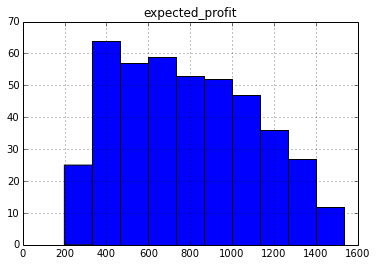

In [14]:
betting_tracker.ix[betting_tracker.idxmax(axis = 0)]
betting_tracker.hist(column='expected_profit')

In [15]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : []}
data = pd.read_csv('../../../data/third_party_preds/betegy-121115.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,expected_profit,single_bet_budget,total_budget
0,85.538598,212.705095,50,100
1,180.577403,253.067323,75,100
2,90.716696,278.521830,100,100
3,-97.616035,307.920393,125,100
4,-99.999457,330.887556,150,100


0.929292929293
                   actual_profit  expected_profit  single_bet_budget  \
actual_profit           1.000000         0.769019           0.484872   
expected_profit         0.769019         1.000000           0.690594   
single_bet_budget       0.484872         0.690594           1.000000   
total_budget            0.433188         0.639424           0.000000   

                   total_budget  
actual_profit          0.433188  
expected_profit        0.639424  
single_bet_budget      0.000000  
total_budget           1.000000  


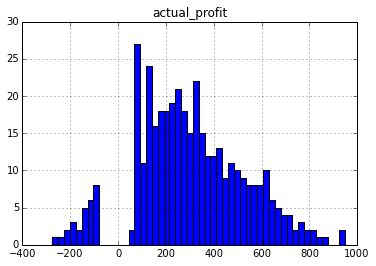

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


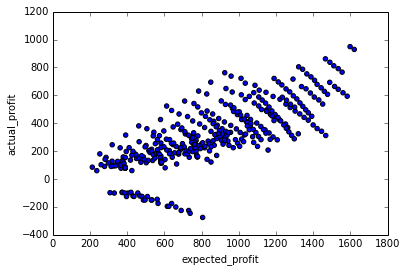

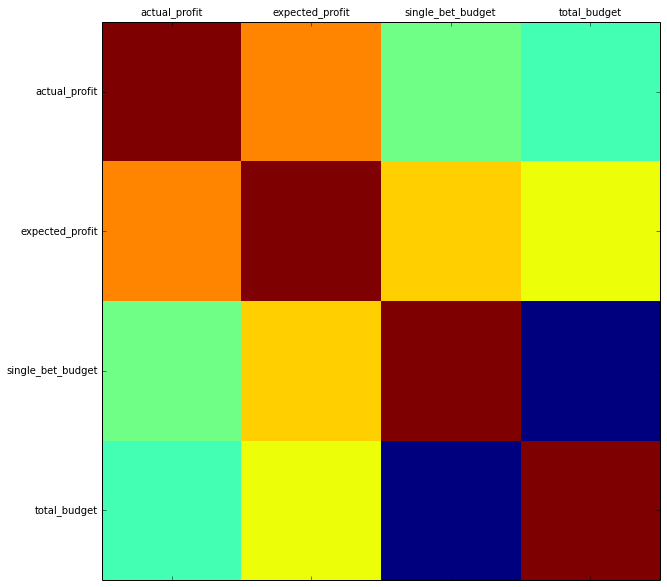

In [16]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

In [17]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : []}
data = pd.read_csv('../../../data/third_party_preds/betegy-120415.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,expected_profit,single_bet_budget,total_budget
0,175.773099,143.316153,50,100
1,164.977273,170.010774,75,100
2,141.015368,189.438221,100,100
3,201.312500,206.606250,125,100
4,261.600000,214.693500,150,100


0.987373737374
                   actual_profit  expected_profit  single_bet_budget  \
actual_profit           1.000000         0.932068           0.539193   
expected_profit         0.932068         1.000000           0.719796   
single_bet_budget       0.539193         0.719796           1.000000   
total_budget            0.678580         0.573547           0.000000   

                   total_budget  
actual_profit          0.678580  
expected_profit        0.573547  
single_bet_budget      0.000000  
total_budget           1.000000  


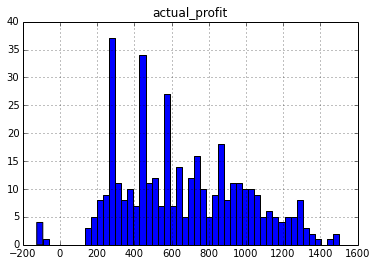

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


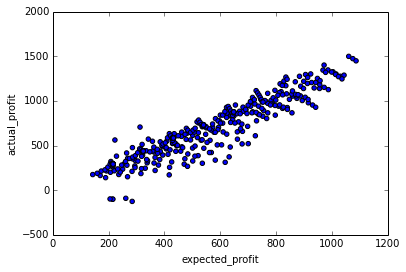

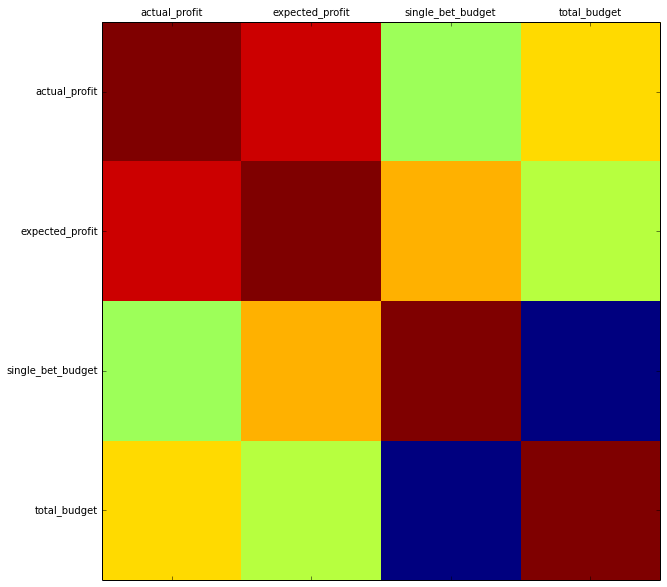

In [18]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

1.0
                   actual_profit  expected_profit  single_bet_budget  \
actual_profit           1.000000         0.969782           0.670494   
expected_profit         0.969782         1.000000           0.807037   
single_bet_budget       0.670494         0.807037           1.000000   
total_budget            0.543438         0.447337           0.000000   

                   total_budget  
actual_profit          0.543438  
expected_profit        0.447337  
single_bet_budget      0.000000  
total_budget           1.000000  


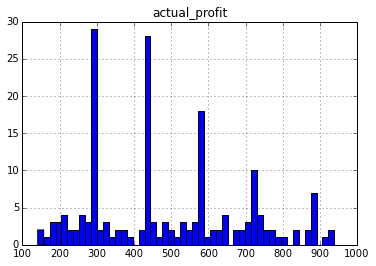

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


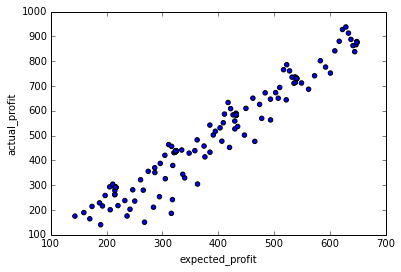

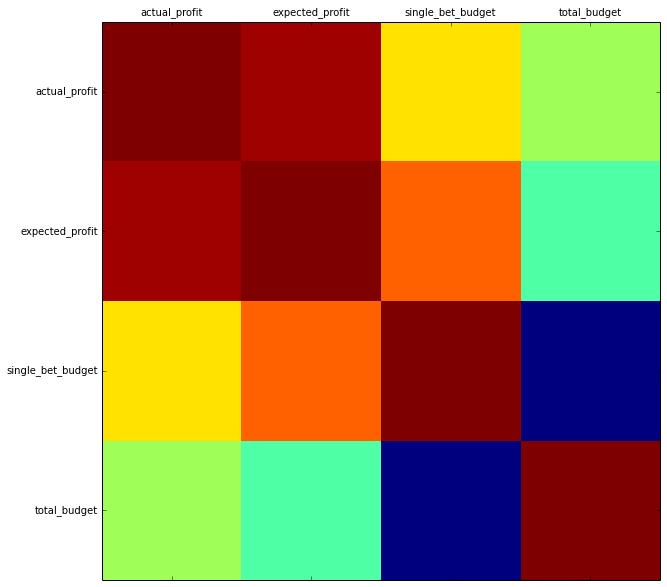

In [19]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 150]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

In [20]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : []}
data = pd.read_csv('../../../data/third_party_preds/baidu-121115.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,expected_profit,single_bet_budget,total_budget
0,30.468292,100.830458,50,100
1,0.591804,112.244303,75,100
2,-43.366484,116.092884,100,100
3,-99.812271,128.914527,125,100
4,-99.865634,133.121296,150,100


0.873737373737
                   actual_profit  expected_profit  single_bet_budget  \
actual_profit           1.000000         0.762672           0.163521   
expected_profit         0.762672         1.000000           0.708910   
single_bet_budget       0.163521         0.708910           1.000000   
total_budget            0.735873         0.555847           0.000000   

                   total_budget  
actual_profit          0.735873  
expected_profit        0.555847  
single_bet_budget      0.000000  
total_budget           1.000000  


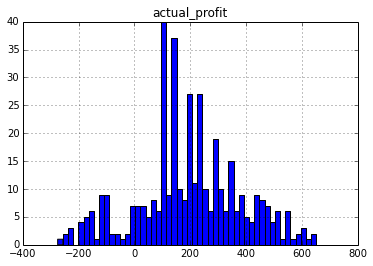

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


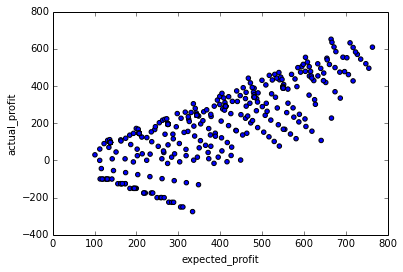

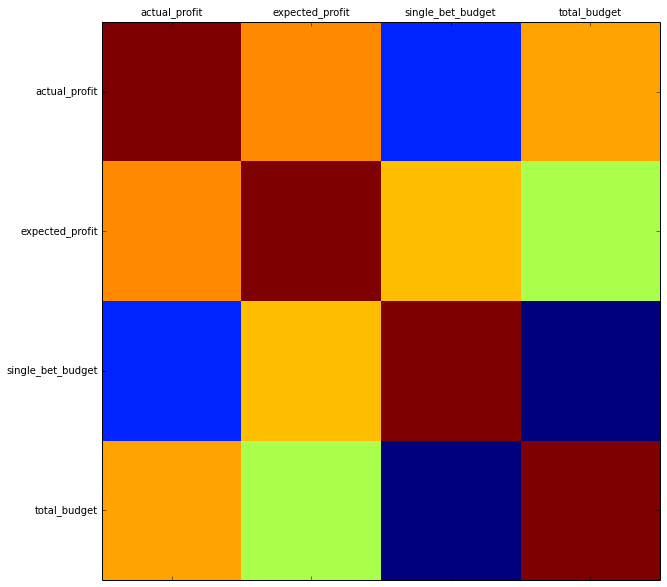

In [21]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)